# Modeling

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# sns.set_theme(style="darkgrid")


from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score

import tensorflow as tf

So now we can read in the data and work on a random forest classifier, since we are working with a categorical target. 

In [2]:
df = pd.read_csv('data/esrb_ratings_scraped.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 30 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   title                     12000 non-null  object
 1   console                   12000 non-null  object
 2   alcohol_reference         12000 non-null  int64 
 3   animated_blood            12000 non-null  int64 
 4   blood                     12000 non-null  int64 
 5   blood_and_gore            12000 non-null  int64 
 6   cartoon_violence          12000 non-null  int64 
 7   crude_humor               12000 non-null  int64 
 8   drug_reference            12000 non-null  int64 
 9   fantasy_violence          12000 non-null  int64 
 10  intense_violence          12000 non-null  int64 
 11  language                  12000 non-null  int64 
 12  mild_blood                12000 non-null  int64 
 13  mild_cartoon_violence     12000 non-null  int64 
 14  mild_fantasy_violence 

Select our features and target

In [3]:
features = df.drop(['title', 'console', 'esrb_rating'], axis=1)
target = df['esrb_rating']

split data into training and test data

In [4]:
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=39)


In our first few iterations we received about 88% accuracy. I then scraped data from ESRB.org to increase the size of the dataset to 6x the size. I reran this notebook with that data and our accuracy dropped to 85%. Let's incorporate SMOTE to see if that can improve.

In [37]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=39)

X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

Now let's initialize our random forest and fit the data. 

In [38]:
rfc_model = RandomForestClassifier(n_estimators=100, random_state=39)

rfc_model.fit(X_train_res, y_train_res)

RandomForestClassifier(random_state=39)

and then let's see how our model works out of the box.

In [40]:
y_pred = rfc_model.predict(X_test)

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.8429166666666666
Classification Report:
               precision    recall  f1-score   support

           E       0.94      0.91      0.92       934
          ET       0.68      0.80      0.74       482
           M       0.88      0.91      0.90       327
           T       0.83      0.74      0.79       657

    accuracy                           0.84      2400
   macro avg       0.83      0.84      0.84      2400
weighted avg       0.85      0.84      0.84      2400



Some of the classes performed better than the others in terms of recall and precision. Let's take a look at this.

In [41]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

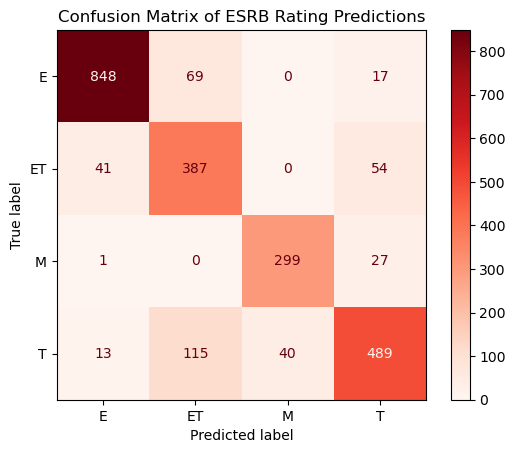

In [42]:
# Generate the confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=rfc_model.classes_)

# Plot the confusion matrix
graph = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=rfc_model.classes_)
graph.plot(cmap=plt.cm.Reds)

# Set title and show plot
plt.title("Confusion Matrix of ESRB Rating Predictions")
plt.show()

Let's try and improve on this model. We can start with checking out feature importance, since we have around 30 features.

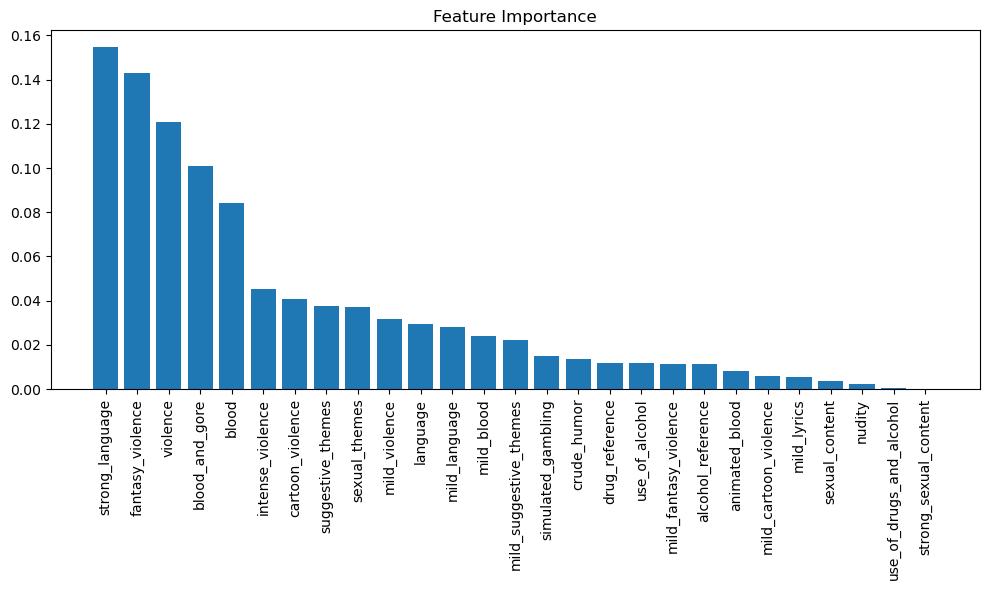

In [43]:
importances = rfc_model.feature_importances_
feature_names = features.columns
sorted_indices = importances.argsort()[::-1]

# Plot the feature importance
plt.figure(figsize=(10, 6))
plt.title("Feature Importance")
plt.bar(range(len(sorted_indices)), importances[sorted_indices], align='center')
plt.xticks(range(len(sorted_indices)), feature_names[sorted_indices], rotation=90)
plt.tight_layout()
plt.show()

Let's try dropping all features that fall belove 0.01

* After trying this step, this results were not warranted. Keeping all features. Moving forward

In [10]:
# # Create a mask for features with importance greater than or equal to 0.01
# mask = importances >= 0.01

# # Filter the features based on the mask
# important_features = feature_names[mask]

# # Drop the features with importance below 0.01 from the dataset
# X_train_reduced = X_train[important_features]
# X_test_reduced = X_test[important_features]

In [11]:
# model.fit(X_train_reduced, y_train)

# y_pred = model.predict(X_test_reduced)

# # Evaluate the model
# print("Accuracy:", accuracy_score(y_test, y_pred))
# print("Classification Report:\n", classification_report(y_test, y_pred))

Our accuracy dropped from that. Let's forgo that and work on another path. We can try a GridSearch

In [44]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(estimator=rfc_model, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)
grid_search.fit(X_train_res, y_train_res)
print("Best Parameters:", grid_search.best_params_)

Fitting 5 folds for each of 108 candidates, totalling 540 fits
Best Parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}


In [45]:
y_grid_pred = grid_search.predict(X_test)

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_grid_pred))
print("Classification Report:\n", classification_report(y_test, y_grid_pred))

Accuracy: 0.8433333333333334
Classification Report:
               precision    recall  f1-score   support

           E       0.94      0.91      0.92       934
          ET       0.68      0.80      0.74       482
           M       0.88      0.91      0.90       327
           T       0.84      0.74      0.79       657

    accuracy                           0.84      2400
   macro avg       0.83      0.84      0.84      2400
weighted avg       0.85      0.84      0.84      2400



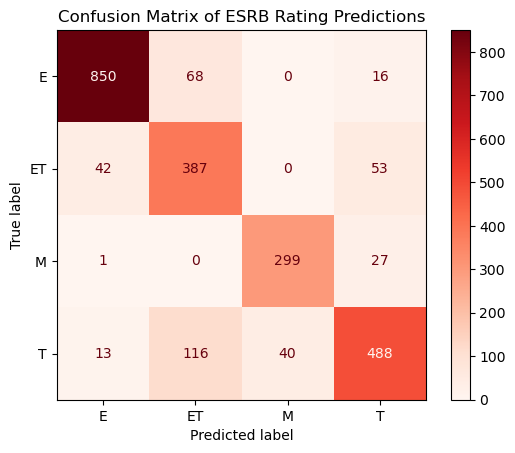

In [46]:
# Generate the confusion matrix
gridCM = confusion_matrix(y_test, y_grid_pred, labels=grid_search.classes_)

# Plot the confusion matrix
graph = ConfusionMatrixDisplay(confusion_matrix=gridCM, display_labels=grid_search.classes_)
graph.plot(cmap=plt.cm.Reds)

# Set title and show plot
plt.title("Confusion Matrix of ESRB Rating Predictions")
plt.show()

We got the exact same numbers. Maybe XGBClassifier will yield improvements?

In [15]:
# Run this cell if you need this library
# !pip install xgboost

We need to encode our target since XGBclassifier is looking for numeric data.

In [47]:
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder

# Encode the ESRB ratings as numeric values
le = LabelEncoder()
y_encoded = le.fit_transform(target)  # Convert 'E', 'T', etc. to numbers

# Split the data into training and testing sets (80% train, 20% test)
X_train_boost, X_test_boost, y_train_boost, y_test_boost = train_test_split(features, y_encoded, test_size=0.2, random_state=39)

smote=SMOTE(random_state=42)
X_train_boost_res, y_train_boost_res = smote.fit_resample(X_train_boost, y_train_boost)

xgb_clf = XGBClassifier(n_estimators=100, learning_rate=0.1, max_depth=5)
xgb_clf.fit(X_train_boost_res, y_train_boost_res)
y_pred_xgb = xgb_clf.predict(X_test_boost)

In [48]:
# Evaluate the model
print("Accuracy:", accuracy_score(y_test_boost, y_pred_xgb))
print("Classification Report:\n", classification_report(y_test_boost, y_pred_xgb))

Accuracy: 0.84375
Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.93      0.92       934
           1       0.68      0.80      0.74       482
           2       0.91      0.89      0.90       327
           3       0.84      0.73      0.78       657

    accuracy                           0.84      2400
   macro avg       0.84      0.84      0.84      2400
weighted avg       0.85      0.84      0.84      2400



Accuracy dropped a bit, it looks like the precision and recall may have improved?

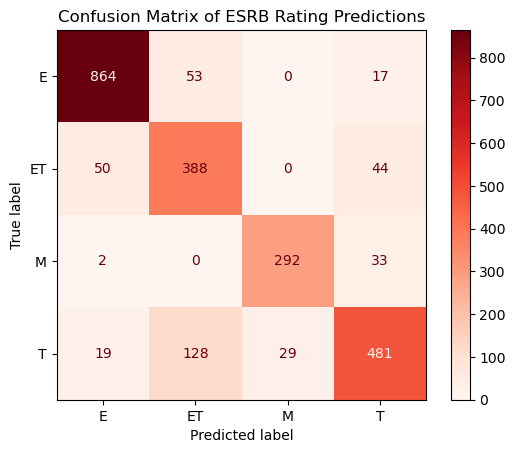

In [49]:
# Generate the confusion matrix
xgbCM = confusion_matrix(y_test_boost, y_pred_xgb)

# Plot the confusion matrix
graph = ConfusionMatrixDisplay(confusion_matrix=xgbCM, display_labels=grid_search.classes_)
graph.plot(cmap=plt.cm.Reds)

# Set title and show plot
plt.title("Confusion Matrix of ESRB Rating Predictions")
plt.show()

Available metrics: odict_keys(['mlogloss'])


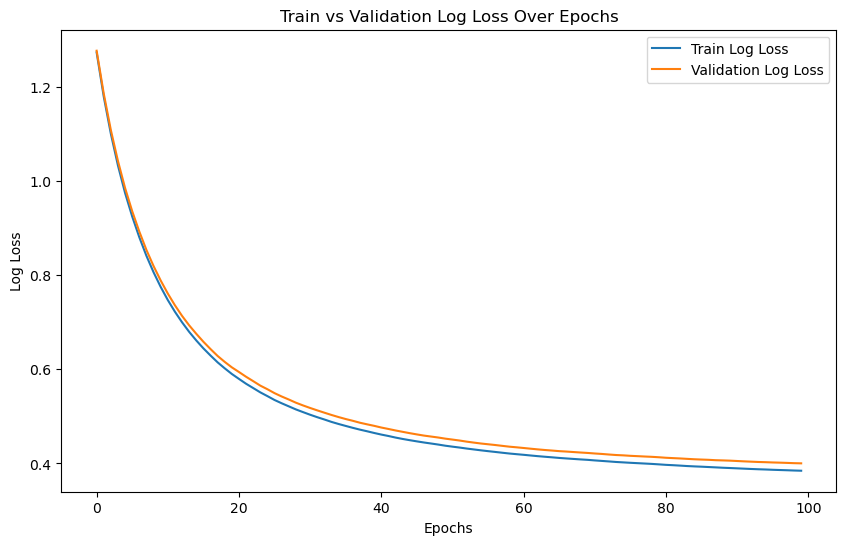

In [50]:
# Define the evaluation set (training and validation data)
eval_set = [(X_train_boost_res, y_train_boost_res), (X_test_boost, y_test_boost)]

# Train the model and track performance
xgb_clf.fit(X_train_boost_res, y_train_boost_res, eval_set=eval_set, verbose=False)

# Retrieve performance metrics
results = xgb_clf.evals_result()

print('Available metrics:', results['validation_0'].keys())

# Extract logloss for training and validation (assuming mlogloss is available for multi-class)
train_metric = results['validation_0']['mlogloss']  # or use 'logloss' for binary classification
test_metric = results['validation_1']['mlogloss']


# Plot the training and validation metric over epochs
epochs = len(train_metric)
x_axis = range(0, epochs)

plt.figure(figsize=(10, 6))

plt.plot(x_axis, train_metric, label='Train Log Loss')
plt.plot(x_axis, test_metric, label='Validation Log Loss')

# Set the plot details
plt.xlabel('Epochs')
plt.ylabel('Log Loss')
plt.title('Train vs Validation Log Loss Over Epochs')
plt.legend()
plt.show()

Doesn't seem to be much in the way of over or underfitting. We aren't getting too much difference. It seems be to dropping as we try more. So let's move onto something more advanced.

_________

## Advanced Machine Learning


______

Let's now try to work on a neural network.

* First iteration: 3 Dense layers.
* Second iteration: changed learning rate to 0.0001
* Third iteration: Added another Dense layer and a dropout layer.
* Fourth iteration: We now have 12k rows of data. We added smote. Accuracy is lower at 85% and stays there very early on in the process. 
* Fifth iteration: Lowering epoch size since learning is stopping. Adding another Dense layer.
* Sixth iteration: Adding a regularizer to help prevent overfitting

In [82]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, LeakyReLU
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.regularizers import l2


# Encode the target variable as integers
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_test_encoded = le.transform(y_test)

# Apply SMOTE to the training data (with integer-encoded labels)
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train_encoded)

# One-hot encode the target variable for use in categorical cross-entropy
y_train_one_hot_res = to_categorical(y_train_res, num_classes=len(le.classes_))
y_test_one_hot = to_categorical(y_test_encoded, num_classes=len(le.classes_))


nn_model = Sequential()
nn_model.add(Dense(256, input_dim=X_train.shape[1], activation='relu', kernel_regularizer=l2(0.01)))
nn_model.add(Dense(128, activation='relu'))
nn_model.add(Dense(64, activation='relu'))
nn_model.add(Dropout(0.6)) # dropout some data to help with overfitting
nn_model.add(Dense(32, activation='relu'))
nn_model.add(Dense(16, activation='relu'))
nn_model.add(Dense(len(le.classes_), activation='softmax'))  # Output layer for classification

# Set a custom learning rate for the Adam optimizer
learning_rate = 0.0001  # You can adjust this value as needed
optimizer = Adam(learning_rate=learning_rate)

nn_model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])


nn_model.summary()


Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_64 (Dense)            (None, 256)               7168      
                                                                 
 dense_65 (Dense)            (None, 128)               32896     
                                                                 
 dense_66 (Dense)            (None, 64)                8256      
                                                                 
 dropout_12 (Dropout)        (None, 64)                0         
                                                                 
 dense_67 (Dense)            (None, 32)                2080      
                                                                 
 dense_68 (Dense)            (None, 16)                528       
                                                                 
 dense_69 (Dense)            (None, 4)               

In [55]:
#train model
history = nn_model.fit(X_train_res, y_train_one_hot_res, epochs=75, batch_size=32, validation_data=(X_test, y_test_one_hot))

Epoch 1/75
472/472 [==============================] - 4s 7ms/step - loss: 1.4604 - accuracy: 0.5923 - val_loss: 0.9933 - val_accuracy: 0.7383
Epoch 2/75
472/472 [==============================] - 3s 7ms/step - loss: 0.8231 - accuracy: 0.7658 - val_loss: 0.6178 - val_accuracy: 0.8221
Epoch 3/75
472/472 [==============================] - 3s 7ms/step - loss: 0.6433 - accuracy: 0.8059 - val_loss: 0.5329 - val_accuracy: 0.8375
Epoch 4/75
472/472 [==============================] - 3s 7ms/step - loss: 0.5825 - accuracy: 0.8155 - val_loss: 0.4943 - val_accuracy: 0.8396
Epoch 5/75
472/472 [==============================] - 3s 7ms/step - loss: 0.5449 - accuracy: 0.8206 - val_loss: 0.4823 - val_accuracy: 0.8438
Epoch 6/75
472/472 [==============================] - 3s 7ms/step - loss: 0.5267 - accuracy: 0.8266 - val_loss: 0.4700 - val_accuracy: 0.8429
Epoch 7/75
472/472 [==============================] - 3s 7ms/step - loss: 0.5100 - accuracy: 0.8299 - val_loss: 0.4679 - val_accuracy: 0.8379
Epoch 

Let's plot to check for overfitting

In [56]:
def plot_ml_acc_loss (history):
    # Plot training & validation accuracy values
    plt.figure(figsize=(12, 6))

    # Accuracy plot
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')

    # Loss plot
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')

    # Show the plots
    plt.tight_layout()
    plt.show()

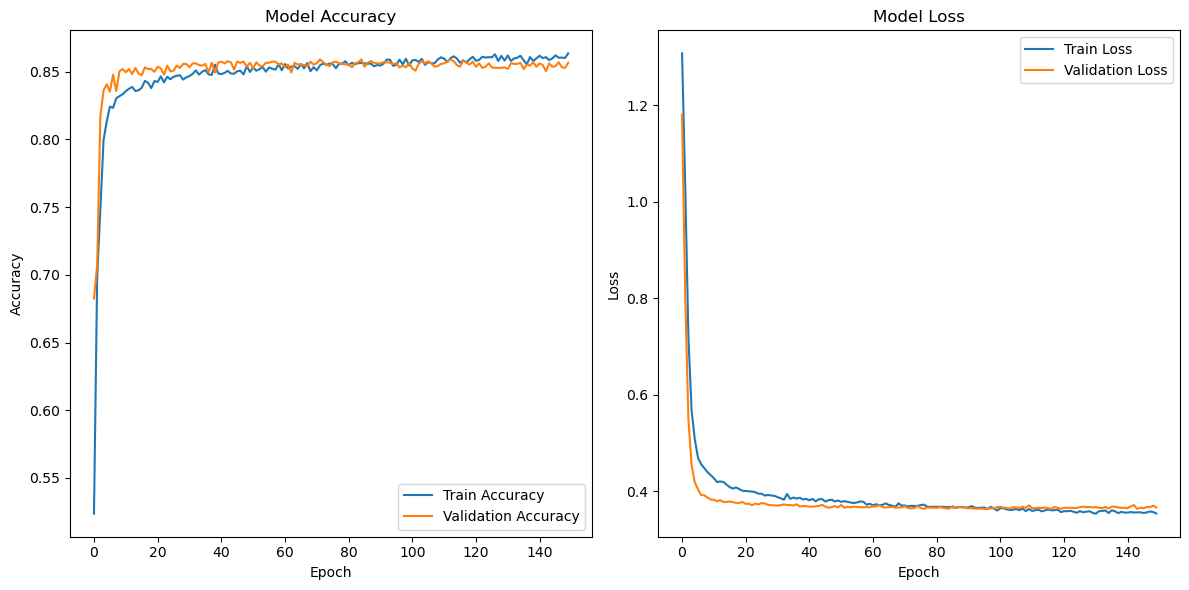

In [22]:
plot_ml_acc_loss(history)

First iteration - It looks like our model accuracy peaks at around 35 epochs and our model loss plateaus at 20 epochs. Let's work on improving that. (Original run through at 0.001 LR)

Changes to 0.0001 learning rate and the graph above looks much more fluid. 

Let's use EarlyStopping and Reduce Learning Rate to try and help with overfitting

In [57]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Add EarlyStopping to stop training when validation loss doesn't improve
early_stopping = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)

# ReduceLROnPlateau: Reduce the learning rate if validation loss plateaus for 3 epochs
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=0.000001)

# Re-train the model with early stopping
history = nn_model.fit(X_train_res, y_train_one_hot_res, epochs=100, batch_size=32, 
                    validation_data=(X_test, y_test_one_hot), 
                    callbacks=[early_stopping, reduce_lr])

# After EarlyStopping, the best model will be restored.
# Evaluate the model on the test set
test_loss, test_accuracy = nn_model.evaluate(X_test, y_test_one_hot)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

Epoch 1/100
472/472 [==============================] - 4s 7ms/step - loss: 0.3894 - accuracy: 0.8500 - val_loss: 0.3951 - val_accuracy: 0.8467 - lr: 1.0000e-04
Epoch 2/100
472/472 [==============================] - 3s 7ms/step - loss: 0.3904 - accuracy: 0.8505 - val_loss: 0.3903 - val_accuracy: 0.8458 - lr: 1.0000e-04
Epoch 3/100
472/472 [==============================] - 3s 7ms/step - loss: 0.3892 - accuracy: 0.8507 - val_loss: 0.3959 - val_accuracy: 0.8487 - lr: 1.0000e-04
Epoch 4/100
472/472 [==============================] - 3s 7ms/step - loss: 0.3875 - accuracy: 0.8528 - val_loss: 0.4114 - val_accuracy: 0.8383 - lr: 1.0000e-04
Epoch 5/100
472/472 [==============================] - 3s 7ms/step - loss: 0.3878 - accuracy: 0.8533 - val_loss: 0.3912 - val_accuracy: 0.8492 - lr: 1.0000e-04
Epoch 6/100
472/472 [==============================] - 3s 7ms/step - loss: 0.3842 - accuracy: 0.8547 - val_loss: 0.4033 - val_accuracy: 0.8462 - lr: 5.0000e-05
Epoch 7/100
472/472 [===================

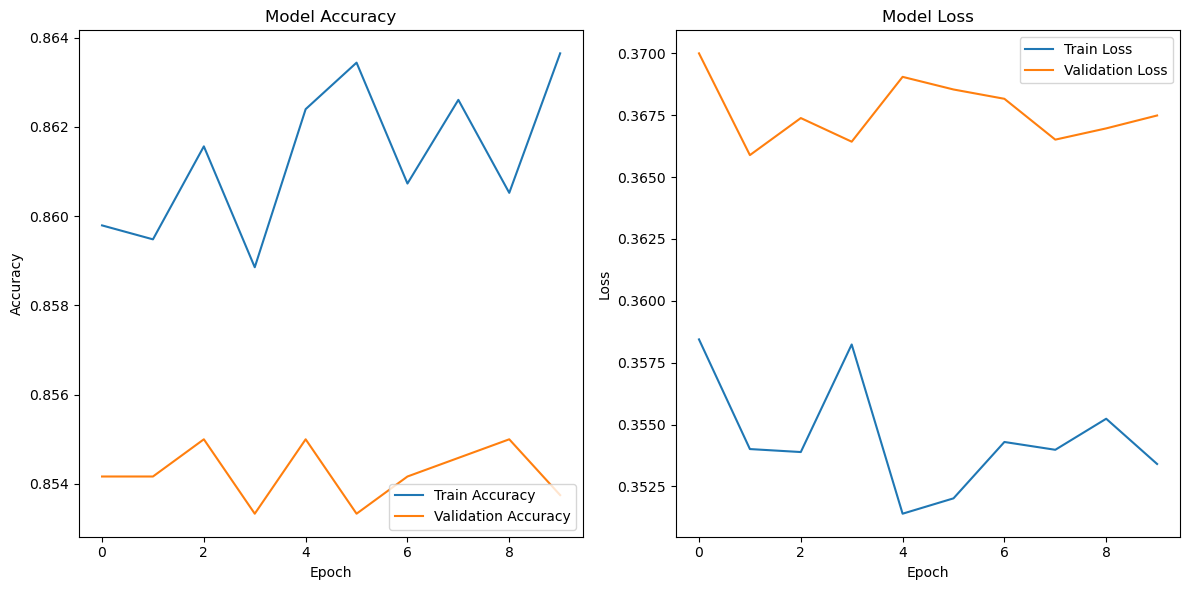

In [24]:
plot_ml_acc_loss(history)

____

## Let's try another optimizer 

____

In [87]:
# Step 1: Encode the target variable using LabelEncoder
le = LabelEncoder()
y_encoded = le.fit_transform(target) 

# Step 2: Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, y_encoded, test_size=0.2, random_state=42)  # X is your features

# Step 3: Apply SMOTE to the training data to handle class imbalance
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

# Step 4: Train an XGBoostClassifier on the resampled data
xgb = XGBClassifier(random_state=42)
xgb.fit(X_train_res, y_train_res)

# Step 5: Evaluate the XGBoost model
y_pred_xgb = xgb.predict(X_test)
print("XGBoost Classification Report:")
print(classification_report(y_test, y_pred_xgb))
print("XGBoost Accuracy: ", accuracy_score(y_test, y_pred_xgb))

# Step 6: Prepare the data for the DNN Sequential model
# One-hot encode the target for use in categorical cross-entropy
y_train_one_hot = to_categorical(y_train_res, num_classes=len(le.classes_))
y_test_one_hot = to_categorical(y_test, num_classes=len(le.classes_))

# Step 7: Define the DNN Sequential model
nn_model = Sequential()
nn_model.add(Dense(128, input_dim=X_train.shape[1]))
nn_model.add(LeakyReLU(alpha=0.1))
nn_model.add(BatchNormalization())  # Batch normalization can help with stability
nn_model.add(Dense(64))
nn_model.add(Dropout(0.5))  # Dropout to reduce overfitting
nn_model.add(Dense(32))
nn_model.add(LeakyReLU(alpha=0.1))
nn_model.add(Dense(len(le.classes_), activation='softmax'))  # Output layer for multi-class classification

# Step 8: Set up the optimizer and compile the model
learning_rate = 0.0001  # Start with a low learning rate
optimizer = Adam(learning_rate=learning_rate)  # Using RMSprop instead of Adam

# Step 9: Add EarlyStopping and ReduceLROnPlateau callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=0.000001)

# Compile the model
nn_model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

nn_model.summary()

XGBoost Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.92      0.94       942
           1       0.71      0.79      0.75       514
           2       0.87      0.89      0.88       294
           3       0.80      0.77      0.79       650

    accuracy                           0.85      2400
   macro avg       0.84      0.84      0.84      2400
weighted avg       0.85      0.85      0.85      2400

XGBoost Accuracy:  0.84875
Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_74 (Dense)            (None, 128)               3584      
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 128)               0         
                                                                 
 batch_normalization_6 (Batc  (None, 128)              512       
 hNormalization)      

In [88]:
history = nn_model.fit(X_train_res, y_train_one_hot, epochs=100, batch_size=32, 
                       validation_data=(X_test, y_test_one_hot),
                       callbacks=[early_stopping, reduce_lr])


Epoch 1/100
471/471 [==============================] - 4s 8ms/step - loss: 0.9955 - accuracy: 0.6387 - val_loss: 0.5574 - val_accuracy: 0.7983 - lr: 1.0000e-04
Epoch 2/100
471/471 [==============================] - 3s 6ms/step - loss: 0.5880 - accuracy: 0.7742 - val_loss: 0.4474 - val_accuracy: 0.8221 - lr: 1.0000e-04
Epoch 3/100
471/471 [==============================] - 3s 6ms/step - loss: 0.5283 - accuracy: 0.7980 - val_loss: 0.4304 - val_accuracy: 0.8246 - lr: 1.0000e-04
Epoch 4/100
471/471 [==============================] - 3s 7ms/step - loss: 0.4953 - accuracy: 0.8040 - val_loss: 0.4164 - val_accuracy: 0.8354 - lr: 1.0000e-04
Epoch 5/100
471/471 [==============================] - 3s 6ms/step - loss: 0.4888 - accuracy: 0.8082 - val_loss: 0.4149 - val_accuracy: 0.8371 - lr: 1.0000e-04
Epoch 6/100
471/471 [==============================] - 3s 7ms/step - loss: 0.4756 - accuracy: 0.8119 - val_loss: 0.4138 - val_accuracy: 0.8396 - lr: 1.0000e-04
Epoch 7/100
471/471 [===================

In [89]:
history = nn_model.fit(X_train_res, y_train_one_hot, epochs=100, batch_size=64, 
                       validation_data=(X_test, y_test_one_hot),
                       callbacks=[early_stopping, reduce_lr])

Epoch 1/100
236/236 [==============================] - 2s 8ms/step - loss: 0.4076 - accuracy: 0.8423 - val_loss: 0.3914 - val_accuracy: 0.8471 - lr: 1.2500e-05
Epoch 2/100
236/236 [==============================] - 2s 7ms/step - loss: 0.4092 - accuracy: 0.8381 - val_loss: 0.3917 - val_accuracy: 0.8462 - lr: 1.2500e-05
Epoch 3/100
236/236 [==============================] - 2s 7ms/step - loss: 0.4102 - accuracy: 0.8371 - val_loss: 0.3919 - val_accuracy: 0.8462 - lr: 1.2500e-05
Epoch 4/100
236/236 [==============================] - 2s 7ms/step - loss: 0.4090 - accuracy: 0.8385 - val_loss: 0.3927 - val_accuracy: 0.8471 - lr: 1.2500e-05
Epoch 5/100
236/236 [==============================] - 1s 6ms/step - loss: 0.4109 - accuracy: 0.8385 - val_loss: 0.3923 - val_accuracy: 0.8462 - lr: 6.2500e-06
Epoch 6/100
236/236 [==============================] - 2s 7ms/step - loss: 0.4090 - accuracy: 0.8417 - val_loss: 0.3926 - val_accuracy: 0.8462 - lr: 6.2500e-06


In [90]:
# Step 10: Evaluate the DNN model
y_pred_nn = nn_model.predict(X_test)
y_pred_nn_classes = y_pred_nn.argmax(axis=1)

print("DNN Classification Report:")
print(classification_report(y_test, y_pred_nn_classes))
print("DNN Accuracy: ", accuracy_score(y_test, y_pred_nn_classes))

75/75 [==============================] - 0s 3ms/step
DNN Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.92      0.94       942
           1       0.70      0.84      0.76       514
           2       0.85      0.89      0.87       294
           3       0.84      0.72      0.77       650

    accuracy                           0.85      2400
   macro avg       0.83      0.84      0.84      2400
weighted avg       0.85      0.85      0.85      2400

DNN Accuracy:  0.8470833333333333


____

## Let's use a smaller dataset for testing

____

Run on new test data.

In [58]:
test_data = pd.read_csv('data/esrb_ratings_test_set.csv')
test_target = 'esrb_rating'

We encode the target column in this new set to match our model

In [59]:
# Encode the ESRB ratings as numeric values
test_le = LabelEncoder()
test_data[test_target] = test_le.fit_transform(test_data[test_target])  # Convert 'E', 'T', etc. to numbers

In [60]:
# 
test_data = test_data.drop(['title', 'console', 'esrb_rating'], axis=1)


In [62]:
# Get predictions from the model
predictions = nn_model.predict(test_data)

# If it's a classification problem and you want the class with the highest probability
predicted_classes = predictions.argmax(axis=1)

1/1 [==============================] - 0s 56ms/step


In [63]:
predicted_classes

array([1, 0, 1, 2, 1], dtype=int64)

In [64]:
predicted_labels = test_le.inverse_transform(predicted_classes)
print(predicted_labels)

['ET' 'E' 'ET' 'M' 'ET']


We were accurate 3 out of 5 times for a single run of this data. The first two ET should be T. Given that the models above were definitely showing some interesting results for T (false positives), it sort of makes sense. 

_____

### Things to work on 

create a script that allows to input feature values by asking user for yes/nos

save data as new row in dataset. 

return rating to user. 